In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
train_data = pd.read_table('train_data.txt')
test_data = pd.read_table('test_data.txt')

print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
print('테스트 리뷰 개수 :',len(test_data)) # 훈련용 리뷰 개수 출력
train_data[:5] # 상위 5개 출력
# label : 긍정(0), 부정(1)

훈련용 리뷰 개수 : 22731
테스트 리뷰 개수 : 18761


,id,point,document,label
0,1218049409,4.0,사람이 너무 많아서 오픈시간쯔음 가도 대기해야해요! 그래도 맛있습니다.,0
1,1218049409,5.0,사람이 항상 많지만 맛있어요,0
2,1218049409,3.5,Dyfigifhcjvjvjv,1
3,1218049409,5.0,샤로수길에서 내가 가장 좋아하는 가게!! 연인과 와도 좋고 친구랑 와도 좋은 곳~~...,0
4,1218049409,5.0,맛있음 왜 사람 많은지 알 것 같음,0


In [3]:
train_data['document'].nunique(), train_data['label'].nunique()
train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(train_data))


총 샘플의 수 : 17036


   label  count
0      0  11809
1      1   5227


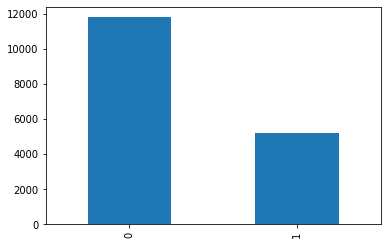

In [4]:
# 긍정,부정 분포도
train_data['label'].value_counts().plot(kind = 'bar')
print(train_data.groupby('label').size().reset_index(name = 'count'))


In [5]:
#리뷰 중 null값 있는지 확인
print(train_data.isnull().values.any()) # Null값 제거 전
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False
False


In [6]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]


,id,point,document,label
0,1218049409,4.0,사람이 너무 많아서 오픈시간쯔음 가도 대기해야해요 그래도 맛있습니다,0
1,1218049409,5.0,사람이 항상 많지만 맛있어요,0
2,1218049409,3.5,,1
3,1218049409,5.0,샤로수길에서 내가 가장 좋아하는 가게 연인과 와도 좋고 친구랑 와도 좋은 곳 데리고...,0
4,1218049409,5.0,맛있음 왜 사람 많은지 알 것 같음,0


In [7]:
# white space 데이터를 empty value로 변경 
train_data['document'] = train_data['document'].str.replace('^ +', "") 
train_data['document'].replace('', np.nan, inplace=True)
train_data = train_data.dropna(how='any') # Null 값 제거

print(train_data.isnull().sum())


id          0
point       0
document    0
label       0
dtype: int64


In [8]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))


전처리 후 테스트용 샘플의 개수 : 13902


In [9]:
## TOKENIZER
#불용어
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

okt = Okt()
okt.morphs('서비스도 많이 주시고 맛있는 식사 잘먹고 갑니다', stem = True)

['서비스', '도', '많이', '주시', '고', '맛있다', '식사', '잘', '먹다', '가다']

In [10]:
X_train = []
for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)


In [11]:
print(X_train[:3])

X_test = []
for sentence in test_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)
    
print(X_test[:3])

[['사람', '너무', '많다', '오픈', '시', '간쯔', '음', '가도', '대기', '해', '요', '그래도', '맛있다'], ['사람', '항상', '많다', '맛있다'], ['샤', '로', '수', '길', '에서', '내', '가장', '좋아하다', '가게', '연인', '와도', '좋다', '친구', '랑', '와도', '좋다', '곳', '데리', '고', '오다', '사람', '다', '만족하다', '돌아가다']]
[['고기', '에서', '냄새', '나', '요'], ['기가맥힌', '추어탕', '맛집', '김치', '맛깔나다'], ['김치', '너무', '맛있다']]


In [12]:
# Make Vocaburary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_test) # 훈련데이터셋 사용
print(tokenizer.word_index)



{'맛있다': 1, '먹다': 2, '좋다': 3, '너무': 4, '맛': 5, '오다': 6, '친절하다': 7, '가다': 8, '여수': 9, '이다': 10, '있다': 11, '맛집': 12, '진짜': 13, '요': 14, '보다': 15, '다': 16, '님': 17, '방문': 18, '게장': 19, '정말': 20, '또': 21, '사장': 22, '음식': 23, '자다': 24, '을': 25, '같다': 26, '나오다': 27, '없다': 28, 'ㅎㅎ': 29, '곳': 30, '많다': 31, '에서': 32, '로': 33, '직원': 34, '않다': 35, '하고': 36, '고': 37, '뷰': 38, '추천': 39, '들다': 40, '안': 41, '넘다': 42, '갈치': 43, '수': 44, '분위기': 45, '여': 46, '깔끔하다': 47, '최고': 48, '만': 49, '반찬': 50, '여행': 51, '되다': 52, '다음': 53, '꼭': 54, '밥': 55, '때': 56, '분들': 57, '조림': 58, '회': 59, '까지': 60, '분': 61, '서비스': 62, '더': 63, '서': 64, '랑': 65, '이랑': 66, '가격': 67, '여기': 68, '집': 69, '완전': 70, '싶다': 71, '기분': 72, '커피': 73, '푸다': 74, '것': 75, '하나': 76, '인데': 77, '양념': 78, '시키다': 79, '해주다': 80, '엄청': 81, '갈다': 82, '아니다': 83, '나': 84, '중': 85, '많이': 86, '이에요': 87, '삼': 88, '나다': 89, '인': 90, '양도': 91, 'ㅠㅠ': 92, '카페': 93, '처음': 94, '바다': 95, '두': 96, '합': 97, '못': 98, '주다': 99, '신선하다': 100, '주문': 101, '가족': 102, '적

In [13]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 9992
등장 빈도가 2번 이하인 희귀 단어의 수: 5498
단어 집합에서 희귀 단어의 비율: 55.0240192153723
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.7187048325894194


In [14]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 4495


In [15]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
print(X_train[:3])


[[69, 5, 23, 396, 142, 551, 897, 577, 269, 14, 247, 1], [69, 154, 23, 1], [218, 19, 48, 156, 28, 241, 589, 109, 117, 2067, 1144, 3, 158, 54, 1144, 3, 35, 1385, 32, 22, 69, 13, 232, 1919]]


In [16]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [18]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))


145007
145007


리뷰의 최대 길이 : 112
리뷰의 평균 길이 : 16.26260726460562


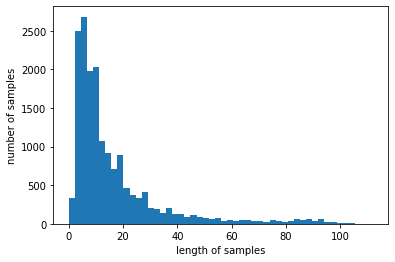

In [17]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [19]:
max_len = 30
below_threshold_len(max_len, X_train)

X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 86.99306453508875


In [20]:
#LSTM
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [21]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [22]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)


In [23]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
226/227 [============================>.] - ETA: 0s - loss: 0.3038 - acc: 0.8791
Epoch 00001: val_acc improved from -inf to 0.59154, saving model to best_model.h5
227/227 [==============================] - 9s 39ms/step - loss: 0.3038 - acc: 0.8791 - val_loss: 0.8882 - val_acc: 0.5915
Epoch 2/15
226/227 [============================>.] - ETA: 0s - loss: 0.2221 - acc: 0.9162
Epoch 00002: val_acc improved from 0.59154 to 0.62592, saving model to best_model.h5
227/227 [==============================] - 9s 39ms/step - loss: 0.2217 - acc: 0.9162 - val_loss: 0.8724 - val_acc: 0.6259
Epoch 3/15
226/227 [============================>.] - ETA: 0s - loss: 0.2029 - acc: 0.9229
Epoch 00003: val_acc did not improve from 0.62592
227/227 [==============================] - 10s 44ms/step - loss: 0.2026 - acc: 0.9231 - val_loss: 0.9376 - val_acc: 0.6048
Epoch 4/15
227/227 [==============================] - ETA: 0s - loss: 0.1885 - acc: 0.9291
Epoch 00004: val_acc improved from 0.62592 to 0.6882

In [24]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

435/435 [==============================] - 4s 8ms/step - loss: 0.1168 - acc: 0.9597

 테스트 정확도: 0.9597


In [25]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score < 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))
    

In [39]:
sentiment_predict('분위기갑. 파스타존맛.재방문각.')

sentiment_predict('비빔은 진짜 강추! 물냉면은 쏘쏘!')

sentiment_predict('머리털 나고 리뷰 처음 남겨봅니다. 거두절미하고 비싸고 양 적고 서비스 최악의 식당을 느껴보고 싶으신 분들께 추천합니다. 그러나 맛과 서비스 등 제값 하는 식당을 원하는 분들께는 비추천합니다.')

sentiment_predict('단아하고좋았어요 근데.. 점심시간이라그런지 코스요리인데도 너무빨리나오고 음식을 빨리먹어야되고.. 음식도 그닥')

sentiment_predict('존맛탱ㅠ 넘 친절하세요 굿굿!!')

1.43% 확률로 긍정 리뷰입니다.

6.99% 확률로 긍정 리뷰입니다.

1.47% 확률로 부정 리뷰입니다.

22.88% 확률로 부정 리뷰입니다.

0.09% 확률로 긍정 리뷰입니다.

